## Import Required Modules

In [ ]:
!gdown '1iNoJeuymN8SObhBQdPIcWULh9ZbE0QcR' --output Split_Datasets_520.zip

Downloading...
From: https://drive.google.com/uc?id=1iNoJeuymN8SObhBQdPIcWULh9ZbE0QcR
To: /content/Split_Datasets_520.zip
100% 407M/407M [00:03<00:00, 119MB/s]


In [ ]:
import cv2
import numpy as np
import os
import shutil
import tensorflow as tf
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
with zipfile.ZipFile('/content/Split_Datasets_520.zip', 'r') as zip:
    zip.extractall('/content/Datasets')

## Data Extract, Transform, and Load

In [ ]:
data_train_dir = "/content/Datasets/train"
data_val_dir = "/content/Datasets/val"
data_test_dir = "/content/Datasets/test"
img_width = 300
img_height = 300
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
)

Found 3328 files belonging to 8 classes.


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(
    data_val_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
)

Found 416 files belonging to 8 classes.


In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(
    data_test_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
)

Found 416 files belonging to 8 classes.


In [ ]:
class_names = train_data.class_names
print(class_names)

['Electronic_Waste', 'Food_Scraps', 'Glass', 'Metalic_Materials', 'Organic_Vegetation_Waste', 'Paper', 'Plastic', 'Textile']


In [ ]:
print(train_data)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Resizing(300, 300)
])

In [ ]:
def preprocess_and_augmentation(data, augment=False, shuffle=False):
    ds = data.map(
        lambda x, y: (tf.keras.applications.xception.preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE
    )
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
train_data = preprocess_and_augmentation(train_data, augment=True, shuffle=True)
val_data = preprocess_and_augmentation(val_data)
test_data = preprocess_and_augmentation(test_data)

In [ ]:
print(train_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>


In [ ]:
print(val_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>


## Training and Testing Model

In [ ]:
base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    input_shape=(300, 300, 3),
    weights='imagenet'
)
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
def trainable_layers(model, num_of_trainable):
  model.trainable = True
  num_layers = len(base_model.layers)
  for layer in model.layers[:(num_layers - num_of_trainable)]:
    layer.trainable = False
  return model

In [ ]:
finetune_model = trainable_layers(base_model, 6)
finetune_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
model = tf.keras.Sequential([
    finetune_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation=tf.keras.activations.softmax)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 21,914,672
Trainable params: 5,801,992
Non-trainable params: 16,112,680
__________________________________

In [ ]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

Epoch 1/10
104/104 [==============================] - 34s 282ms/step - loss: 0.5615 - accuracy: 0.8128 - val_loss: 0.3023 - val_accuracy: 0.9135
Epoch 2/10
104/104 [==============================] - 29s 278ms/step - loss: 0.1097 - accuracy: 0.9639 - val_loss: 0.4248 - val_accuracy: 0.9159
Epoch 3/10
104/104 [==============================] - 29s 275ms/step - loss: 0.0370 - accuracy: 0.9892 - val_loss: 0.4284 - val_accuracy: 0.9087
Epoch 4/10
104/104 [==============================] - 29s 277ms/step - loss: 0.0450 - accuracy: 0.9880 - val_loss: 0.3934 - val_accuracy: 0.9231
Epoch 5/10
104/104 [==============================] - 28s 274ms/step - loss: 0.0440 - accuracy: 0.9871 - val_loss: 0.5690 - val_accuracy: 0.9111
Epoch 6/10
104/104 [==============================] - 28s 274ms/step - loss: 0.0897 - accuracy: 0.9745 - val_loss: 0.5899 - val_accuracy: 0.9014
Epoch 7/10
104/104 [==============================] - 29s 276ms/step - loss: 0.0560 - accuracy: 0.9826 - val_loss: 0.4105 - val_ac

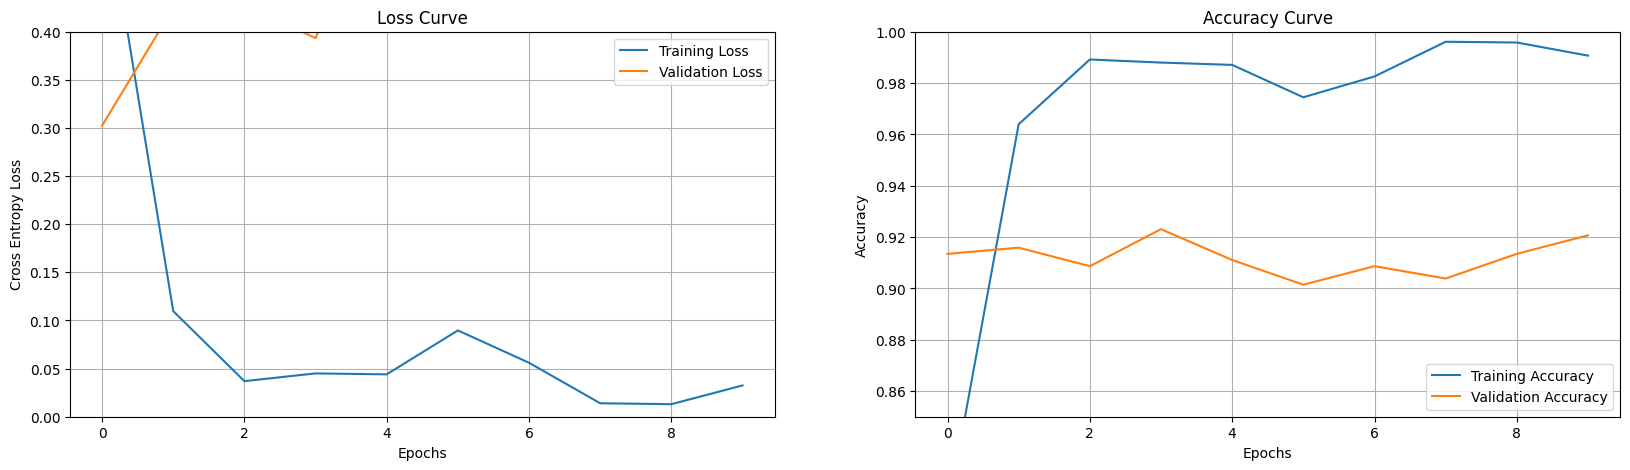

In [ ]:
# Collect the history of the training run
history = pd.DataFrame(history.history)

# Create a figure to display the model's performance
plt.figure(figsize=(20, 5))

# Plot the loss curve in the first subplot
plt.subplot(1, 2, 1)
plt.title("Loss Curve")
plt.plot(history['loss'], label="Training Loss")
plt.plot(history['val_loss'], label="Validation Loss")

# Horizontal line to show the testing performance
# plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.ylim([0, 0.4])

# Show the legend and grid
plt.legend()
plt.grid()

# Plot the accuracy curve in the second subplot
plt.subplot(1, 2, 2)
plt.title("Accuracy Curve")
plt.plot(history['accuracy'], label="Training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")

# Horizontal line to show the testing performance
# plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.85, 1])

# Show the legend and grid
plt.legend()
plt.grid()

# Display the plot
plt.show()

In [ ]:
results = model.evaluate(test_data, batch_size=32)
print("test loss, test acc:", results)

13/13 [==============================] - 3s 220ms/step - loss: 0.4143 - accuracy: 0.9207
test loss, test acc: [0.414288729429245, 0.9206730723381042]


## Saving Model

In [ ]:
model.save('model-waste_classification-v2_2.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shutil.copy('/content/model-waste_classification-v2_2.h5', '/content/drive/MyDrive/CNN Models')

'/content/drive/MyDrive/CNN Models/model-waste_classification-v2_2.h5'